# DATA PREPARATION PIPELINE
## __P17DE100LOG__
## __P17DE2000LOG__

by __Pawel Rosikiewicz__ 

---

* no scaling applied, only log2FC provided as input data
* it keeps the rank of expressed genes

## Setup
---

__global imports__
* I purposely placed other imports, such as my custom made functions for thsi project in each section
* to allow you fast inspection of my code, but also, copying these important to new notebooks, for pipeline development

In [2]:
import os
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import warnings
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn import set_config
from sklearn.preprocessing import RobustScaler # creates custom transfomers
from sklearn.preprocessing import FunctionTransformer # creates custom transfomers
from sklearn.pipeline import make_pipeline, Pipeline # like pipeline function, but give step names automatically, 
from sklearn.compose import ColumnTransformer # allows using different transformers to different columns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, KBinsDiscretizer # skleanr transformers,
from sklearn.decomposition import PCA

In [3]:
# basedir
basedir = os.path.dirname(os.getcwd())
os.chdir(basedir)
sys.path.append(basedir)

In [4]:
# paths
PATH_data_raw     = os.path.join(basedir, "data/raw")
PATH_data_interim = os.path.join(basedir, "data/interim")
PATH_results      = os.path.join(basedir, "data/results")
PATH_models       = os.path.join(basedir, "models")

__load functions, and classes created for that project__

In [5]:
from src.utils.helper_data_loaders import load_tsv
from src.utils.helper_merge_dfs import merge_data
from src.utils.PREPROCESSING_PIPELINE02_LOG import data_preprocessing_pipeline


## __PARAMTERES FOR DATA PREP PIPELINE__ 
---

### __(A) P17 - PATIENT DATA - ALL FEATURES -__

In [6]:
# main variable groups, and types
VAR_GROUPS = dict(
    TARGET_VAR = ["target"],
    CATEGORICAL_VAR = [ 'Baseline ECOG Score', 'Enrollment IC', 'IC Level', 'TC Level', 'Immune phenotype', 'Sex',
           'TCGA Subtype', 'Lund', 'Lund2', 'Received platinum',
           'Met Disease Status', 'Sample age', 'Sample collected pre-platinum',
           'Intravesical BCG administered', 'Tobacco Use History'],
    QUANTITATIVE_VAR = ['FMOne mutation burden per MB', 'Neoantigen burden per MB'],
)

# variable encoding in data_cov
VAR_DTYPES = {
    "TARGET_VAR": "int", # only for EDA
    "CATEGORICAL_VAR": "O",
    "QUANTITATIVE_VAR": "float64"
}

# target variable encoding
TARGET_ENCODING = {0:"non-responder", 1:"responder"}

# list potential confounding variables, used to stratify the results
CONFOUNDING_VAR = ['Sex', 'Tobacco Use History']

### __(B) G100 & G2000 - GENE EXPR. DATA - 1000 & 2000 DIFFERENTIALLY EXPRESSED GENES__
* these are approaxime number of de genes selected wiht the parameters, 
* G100 may have anything from 85 to 150 de genes detected
* G2000 may have from 15000 - 2800 de genes, depending on samples configuration
* Pca on G2000 will always be 150 features

In [7]:
# parameters for data preparation
parameters = {
    'P17_G100_LOG':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.5, Ptr=0.05, create_plot=True),
        'pca_n_components':0 # no pca
     },
    'P17_G2000_LOG':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None # no pca
     },
    'P17_G2000_LOG_PCA':{
        'zv_filter_dct':dict(na_tr=0.5),
        'sp_filter_dct':dict(tr=-1, quantile=False),
        'select_genes_dct':dict(Log2FCtr=0.2, Ptr=0.2, create_plot=True),
        'pca_n_components':None # pca on all available features
     }    
}

## __LOAD DATA__ 
---

In [8]:
# load target data
data_cov =  load_tsv(PATH_data_raw, 'X_covariates.tsv')
data_genes = load_tsv(PATH_data_raw, 'X_genes.tsv')
data_cov_test =  load_tsv(PATH_data_raw, 'X_covariates_test.tsv')
data_genes_test = load_tsv(PATH_data_raw, 'X_genes_test.tsv')
target = load_tsv(PATH_data_raw, 'y.tsv', header=None)

# small correction
target.columns=[VAR_GROUPS["TARGET_VAR"][0]]
target = pd.Series(target.iloc[:,0])

(200, 17)
(200, 31085)
(98, 17)
(98, 31085)
(200, 1)


## __DATA PREP PIPELINE__ 
---

### __(A) PREPROCESSING PIPELINE FOR PATIENT DATA__

In [9]:
# input data, to get all column names
df = data_cov.copy()

# inputs
numeric_features = VAR_GROUPS["QUANTITATIVE_VAR"].copy()

# find all other features in input data
all_other_features = df.columns.values.tolist()
for v in numeric_features:
    try:
        all_other_features.remove(v)
    except:
        pass
    
# create custom transformer
log_scale_transformer = make_pipeline( 
    FunctionTransformer(np.abs, validate=False),   
    FunctionTransformer(np.log1p, validate=False), # creates runtime warning if negative data are used
    StandardScaler()
)

# create data preprocessor for numeric features
numeric_transformer = Pipeline(steps=[
        ("imputer",SimpleImputer(strategy='mean')), 
        ("scaler",StandardScaler())
    ])

# create data preprocessor for numeric features
categorical_transformer = Pipeline(steps=[
        ("first_imputer",SimpleImputer(strategy='most_frequent')),
        ("onehot", OneHotEncoder(handle_unknown='ignore')), 
    ]) # drop='first', 
    # comment: you can drop first and ignore new, following: 
    # .. https://scikit-learn.org/stable/developers/advanced_installation.html

# preprocessor for all the data
''' ColumnTransformer: it allows apllying different tranfomers to different columns
    - give unique names for each transformer
    - passthrough - keyword, nothing is done with that column
    - column names are always provided as LIST
'''
preprocessor = make_pipeline(
    ColumnTransformer(
        transformers = [
            ("numeric_features", numeric_transformer, numeric_features),
            ("other_features", categorical_transformer, all_other_features), # "passthrough" other option,     
        ], 
        remainder='drop'
    ))

# check if everythign is ok
set_config(display="diagram") # or "text"
preprocessor

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric_features',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['FMOne mutation burden per '
                                                   'MB',
                                                   'Neoantigen burden per MB']),
                                                 ('other_features',
                                                  Pipeline(steps=[('first_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Enrollment IC', 'IC Level',
                                                   'TC Level',
                                                   'Immune phenotype', 'Sex',
                                                   'TCGA Subtype', 'Lund',
                                                   'Lund2', 'Received platinum',
                                                   'Met Disease Status',
                                                   'Sample age',
                                                   'Sample collected '
                                                   'pre-platinum',
                                                   'Intravesical BCG '
                                                   'administered',
                                                   'Baseline ECOG Score',
                                                   'Tobacco Use History'])]))])

In [10]:
# test
eg = preprocessor.fit_transform(data_cov.iloc[0:40, :])
eg2 = preprocessor.transform(data_cov_test)

print(eg.shape, eg2.shape)

(40, 50) (98, 50)


### __(B) FULL PREPROCESSING PIEPLINE__

__Create custom function for detecting differencially expressed genes, between the two classe with tstudent test and foldchnage__
* I applied this, method, as the siples possible option, 
* it can be replaced at any moent with another method, 
* more informaiton on the topic can be found here:
    * "Detecting differentially expressed genes in heterogeneous diseases using half Student’s t-test" https://academic.oup.com/ije/article/39/6/1597/736515
    * "Robustness of differential gene expression analysis of RNA-seq" https://doi.org/10.1016/j.csbj.2021.05.040

In [11]:
# final parameters
n = 50
path = PATH_data_interim
random_nr_list = [0,1,2]

50
150

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149] 



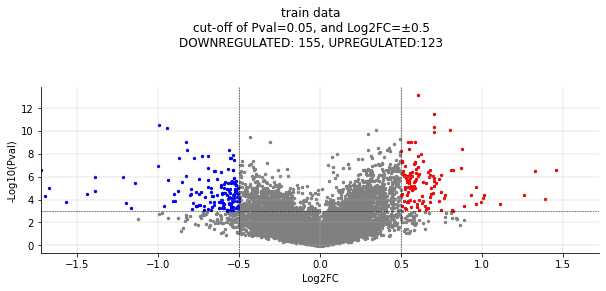


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.9%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.9%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18529       278   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.8   
mean tpm value recorded                                       3.1       3.9   
max tpm value recorded                                       18.3      15.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     98.2%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.9%     75.9%   

                                                 after pca  
sample nr                                              150  
gene nr                                                278  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 278 
differencially expressed genes
............................................................


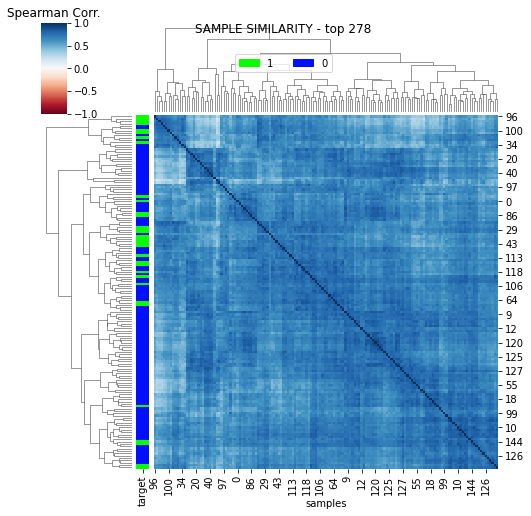

............................................................
GENE EXPRESSION IN THE TOP 
 278 differencially expressed genes
............................................................


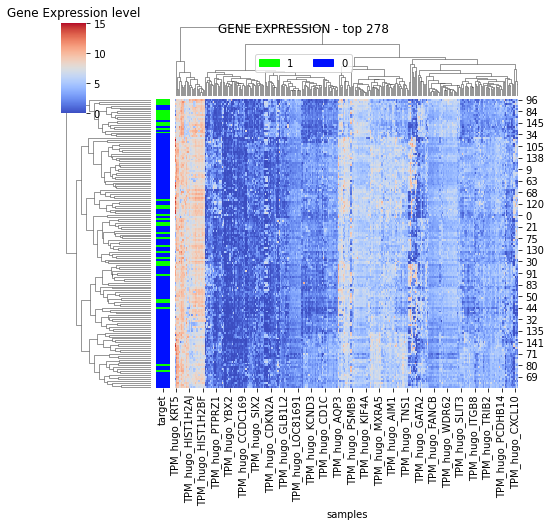

............................................................
PCA and tSNE analysis
............................................................


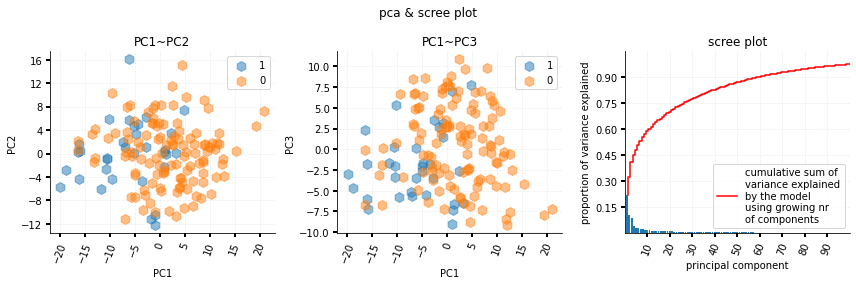


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.3   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            104327.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.9%  59.9%   
% of genes not expressed in any sample               22.2%  22.2%   
% of genes expressed in at least 50%  of samples     59.5%  59.5%   
% of genes expressed in all samples                  46.4%  46.4%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.7%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.0%   
% of genes expressed in all samples                     77.8%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.7%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.0%   
% of genes expressed in all samples                            77.8%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18529       278   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.7   
mean tpm value recorded                                       3.1       3.9   
max tpm value recorded                                       16.7      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.7%     98.3%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.0%    100.0%   
% of genes expressed in all samples                         77.8%     85.3%   

                                                 after pca  
sample nr                                               50  
gene nr                                                278  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.1%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.5%   
% of genes expressed in all samples                            76.5%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18529       278   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.8   
mean tpm value recorded                                       3.1       3.9   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.1%     98.2%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.5%     99.6%   
% of genes expressed in all samples                         76.5%     81.7%   

                                                 after pca  
sample nr                                               98  
gene nr                                                278  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 278)
df2 shape:  (150, 50)
final df:  (150, 328)

validation data ...
df1 shape:  (50, 278)
df2 shape:  (50, 50)
final df:  (50, 328)

test data ...
df1 shape:  (98, 278)
df2 shape:  (98, 50)
final df:  (98, 328)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G100_LOG_v0__transf_data_dct.p
SAVED:  P17_G100_LOG_v0__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

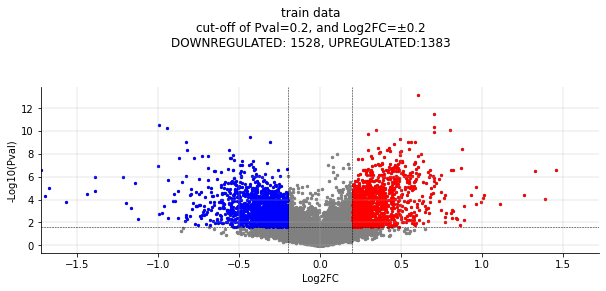


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.9%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.9%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.3   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       18.3      15.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     98.1%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.9%     81.3%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -48.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2911 
differencially expressed genes
............................................................


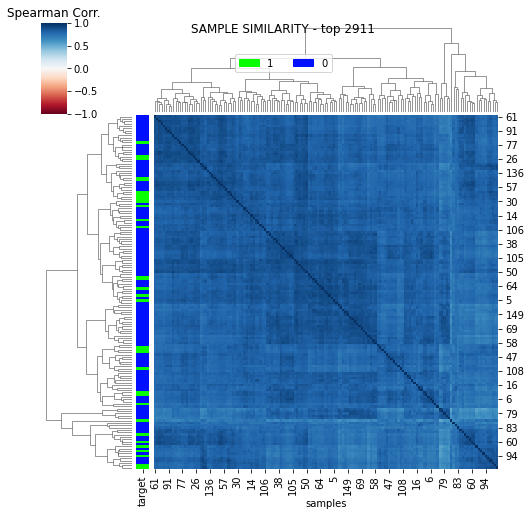

............................................................
GENE EXPRESSION IN THE TOP 
 2911 differencially expressed genes
............................................................


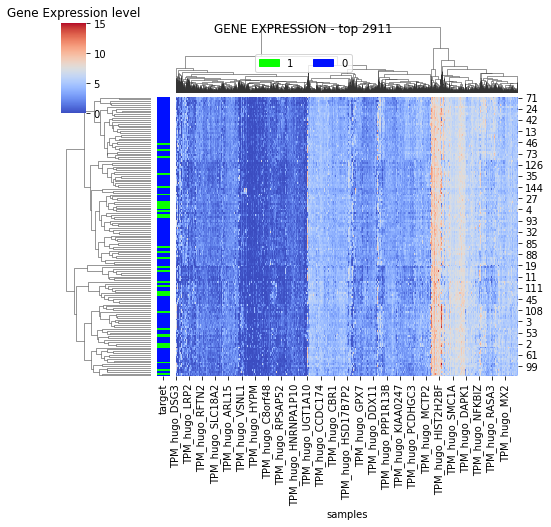

............................................................
PCA and tSNE analysis
............................................................


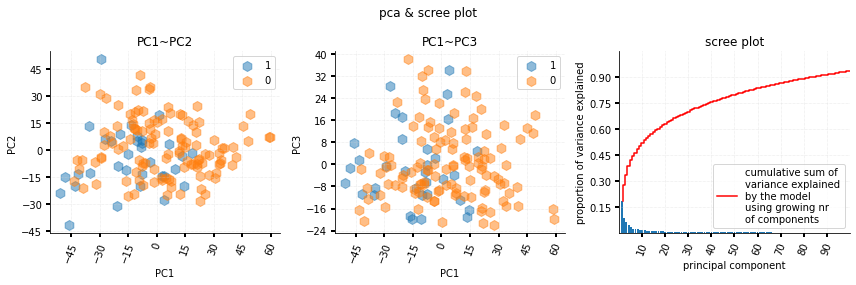


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.3   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            104327.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.9%  59.9%   
% of genes not expressed in any sample               22.2%  22.2%   
% of genes expressed in at least 50%  of samples     59.5%  59.5%   
% of genes expressed in all samples                  46.4%  46.4%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.7%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.0%   
% of genes expressed in all samples                     77.8%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.7%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.0%   
% of genes expressed in all samples                            77.8%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.2   
mean tpm value recorded                                       3.1       3.4   
max tpm value recorded                                       16.7      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.7%     98.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.0%     99.7%   
% of genes expressed in all samples                         77.8%     85.4%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -42.2  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.1%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.5%   
% of genes expressed in all samples                            76.5%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.3   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.1%     98.2%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.5%     99.9%   
% of genes expressed in all samples                         76.5%     84.1%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -40.7  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_v0__transf_data_dct.p
SAVED:  P17_G2000_LOG_v0__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,

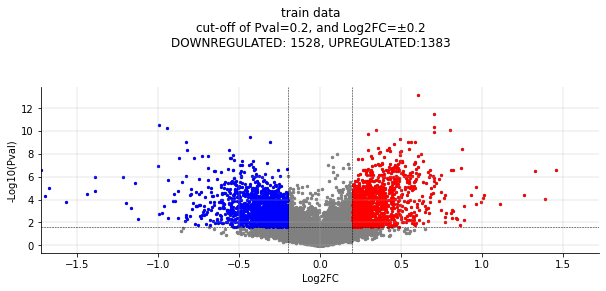


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.1%  60.1%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.6%  59.6%   
% of genes expressed in all samples                  44.0%  44.0%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.9%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.9%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.3   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       18.3      15.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     98.1%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.9%     81.3%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -48.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2911 
differencially expressed genes
............................................................


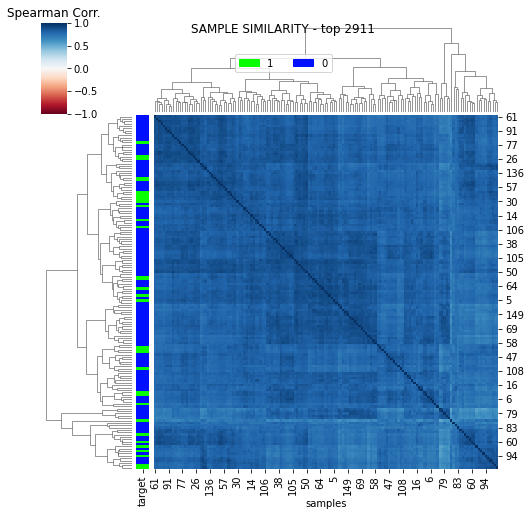

............................................................
GENE EXPRESSION IN THE TOP 
 2911 differencially expressed genes
............................................................


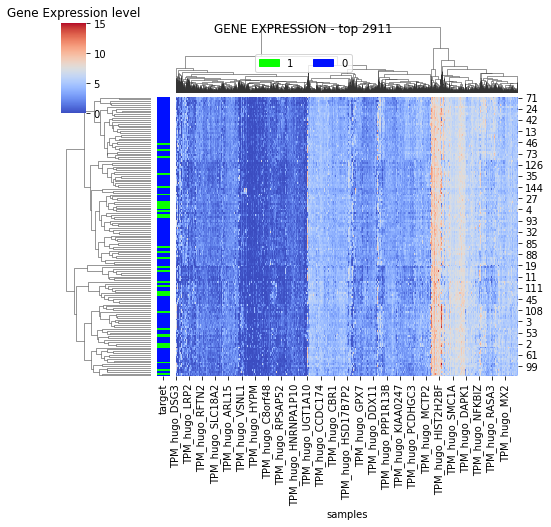

............................................................
PCA and tSNE analysis
............................................................


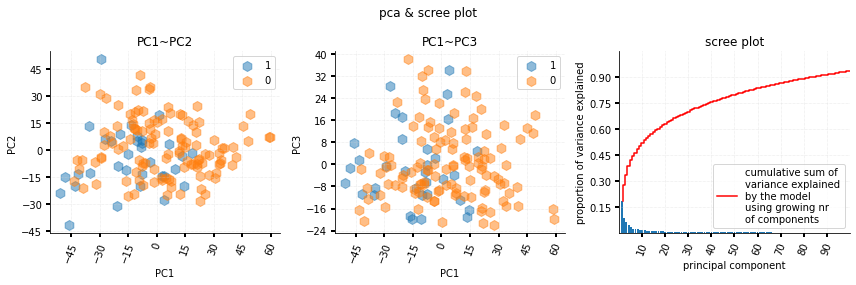


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.3   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            104327.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.9%  59.9%   
% of genes not expressed in any sample               22.2%  22.2%   
% of genes expressed in at least 50%  of samples     59.5%  59.5%   
% of genes expressed in all samples                  46.4%  46.4%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.7%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.0%   
% of genes expressed in all samples                     77.8%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.7%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.0%   
% of genes expressed in all samples                            77.8%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.2   
mean tpm value recorded                                       3.1       3.4   
max tpm value recorded                                       16.7      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.7%     98.0%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.0%     99.7%   
% of genes expressed in all samples                         77.8%     85.4%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -42.2  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18529   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.1%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.5%   
% of genes expressed in all samples                     76.5%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18529   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.1%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.5%   
% of genes expressed in all samples                            76.5%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18529      2911   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.3   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.1%     98.2%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.5%     99.9%   
% of genes expressed in all samples                         76.5%     84.1%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -40.7  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_PCA_v0__transf_data_dct.p
SAVED:  P17_G2000_LOG_PCA_v0__qc_reports_dct.p
50
150

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,

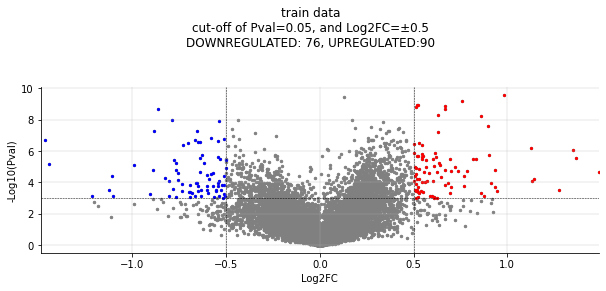


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.5%  18.5%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.9%  43.9%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.8%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.8%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18480       166   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       18.3      11.6   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     96.6%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.8%     62.7%   

                                                 after pca  
sample nr                                              150  
gene nr                                                166  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 166 
differencially expressed genes
............................................................


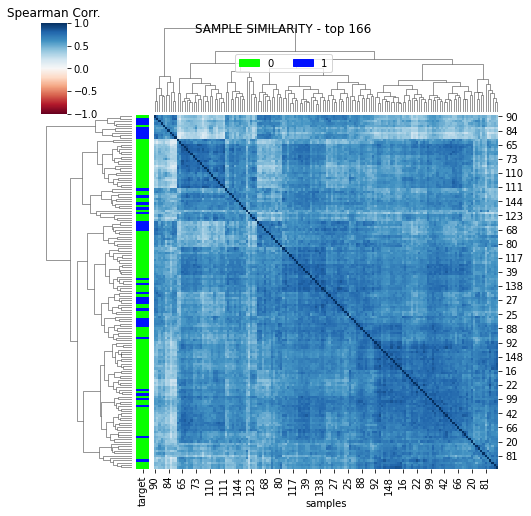

............................................................
GENE EXPRESSION IN THE TOP 
 166 differencially expressed genes
............................................................


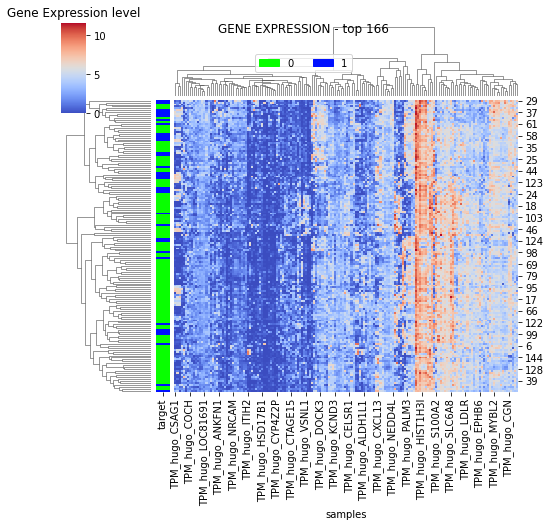

............................................................
PCA and tSNE analysis
............................................................


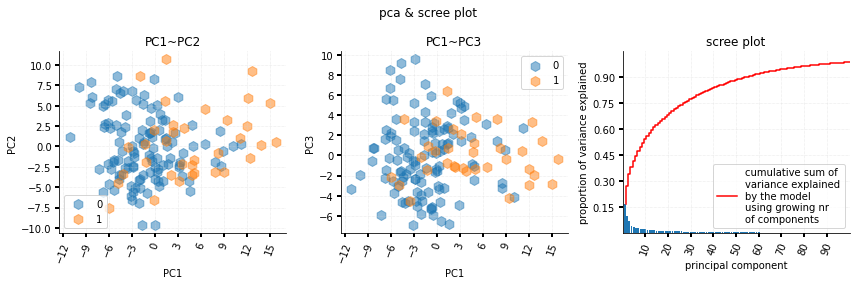


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            136465.8   17.1   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               21.9%  21.9%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  47.1%  47.1%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.1   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     79.2%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.1   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            79.2%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18480       166   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.2   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       17.1      12.4   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     96.5%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%    100.0%   
% of genes expressed in all samples                         79.2%     71.1%   

                                                 after pca  
sample nr                                               50  
gene nr                                                166  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.6%   
% of genes expressed in all samples                            76.7%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18480       166   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       17.0      13.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     96.7%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.6%    100.0%   
% of genes expressed in all samples                         76.7%     68.1%   

                                                 after pca  
sample nr                                               98  
gene nr                                                166  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 166)
df2 shape:  (150, 50)
final df:  (150, 216)

validation data ...
df1 shape:  (50, 166)
df2 shape:  (50, 50)
final df:  (50, 216)

test data ...
df1 shape:  (98, 166)
df2 shape:  (98, 50)
final df:  (98, 216)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G100_LOG_v1__transf_data_dct.p
SAVED:  P17_G100_LOG_v1__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

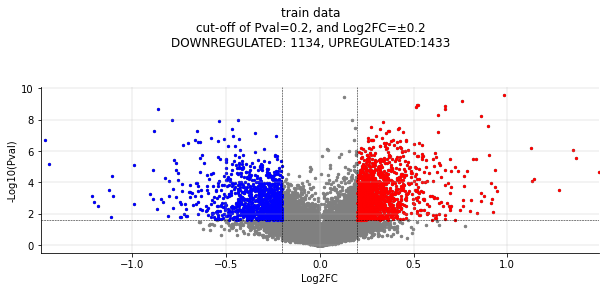


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.5%  18.5%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.9%  43.9%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.8%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.8%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       18.3      15.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     97.8%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.8%     79.5%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -41.3  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2567 
differencially expressed genes
............................................................


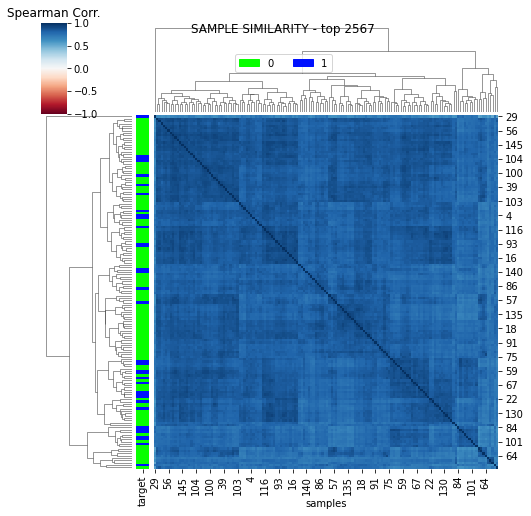

............................................................
GENE EXPRESSION IN THE TOP 
 2567 differencially expressed genes
............................................................


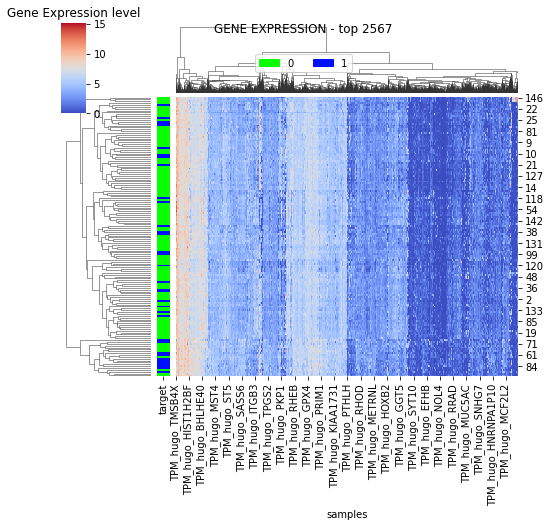

............................................................
PCA and tSNE analysis
............................................................


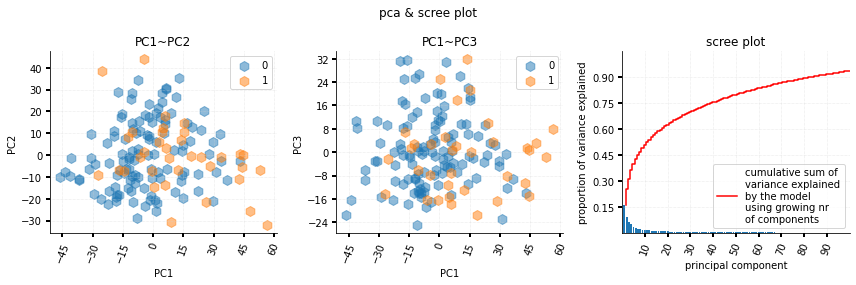


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            136465.8   17.1   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               21.9%  21.9%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  47.1%  47.1%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.1   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     79.2%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.1   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            79.2%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.1      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     97.9%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%     99.9%   
% of genes expressed in all samples                         79.2%     84.9%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -37.0  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.6%   
% of genes expressed in all samples                            76.7%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     97.9%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.6%     99.9%   
% of genes expressed in all samples                         76.7%     83.2%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -38.6  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_v1__transf_data_dct.p
SAVED:  P17_G2000_LOG_v1__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,

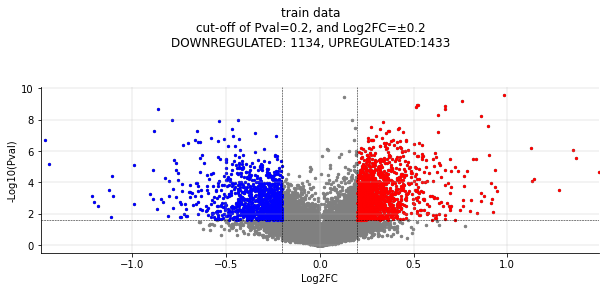


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.0%  60.0%   
% of genes not expressed in any sample               18.5%  18.5%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  43.9%  43.9%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     73.8%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            73.8%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       18.3      15.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     97.8%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         73.8%     79.5%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -41.3  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 2567 
differencially expressed genes
............................................................


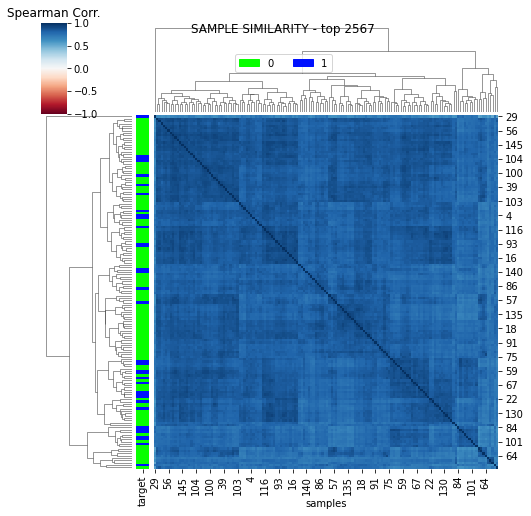

............................................................
GENE EXPRESSION IN THE TOP 
 2567 differencially expressed genes
............................................................


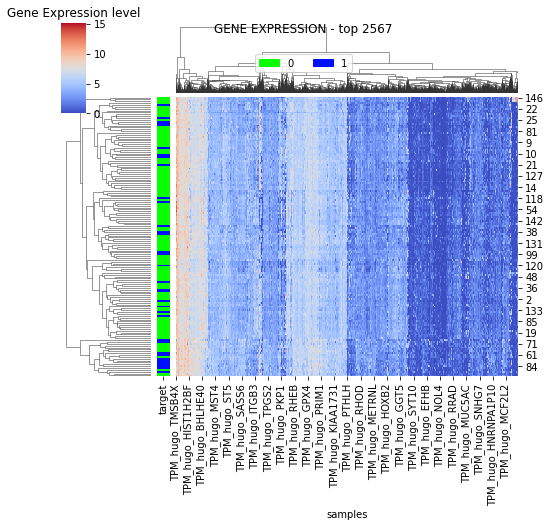

............................................................
PCA and tSNE analysis
............................................................


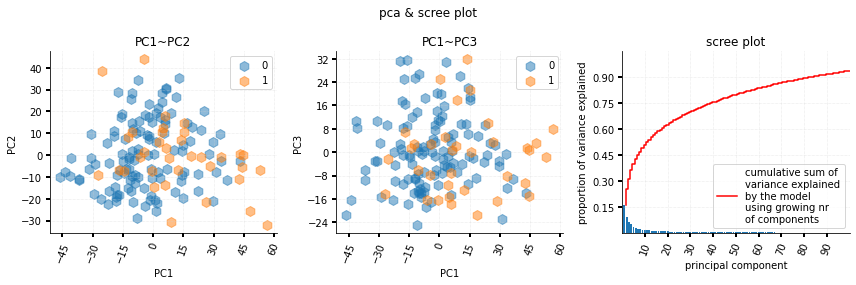


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            136465.8   17.1   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               21.9%  21.9%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  47.1%  47.1%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.1   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     79.2%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.1   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            79.2%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.1      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     97.9%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%     99.9%   
% of genes expressed in all samples                         79.2%     84.9%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -37.0  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18480   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.2%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.6%   
% of genes expressed in all samples                     76.7%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18480   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.2%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.6%   
% of genes expressed in all samples                            76.7%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18480      2567   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.5   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.2%     97.9%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.6%     99.9%   
% of genes expressed in all samples                         76.7%     83.2%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -38.6  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_PCA_v1__transf_data_dct.p
SAVED:  P17_G2000_LOG_PCA_v1__qc_reports_dct.p
50
150

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,

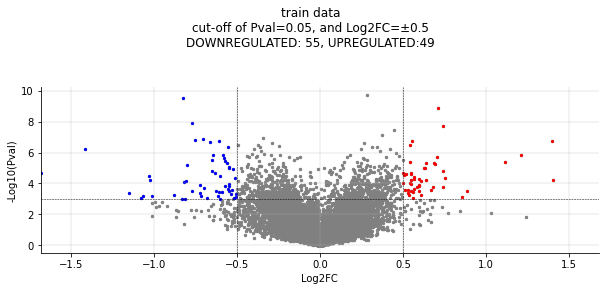


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.6%  44.6%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.7%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            74.7%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18550       104   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.8   
max tpm value recorded                                       18.3      13.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     97.6%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         74.7%     64.4%   

                                                 after pca  
sample nr                                              150  
gene nr                                                104  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 104 
differencially expressed genes
............................................................


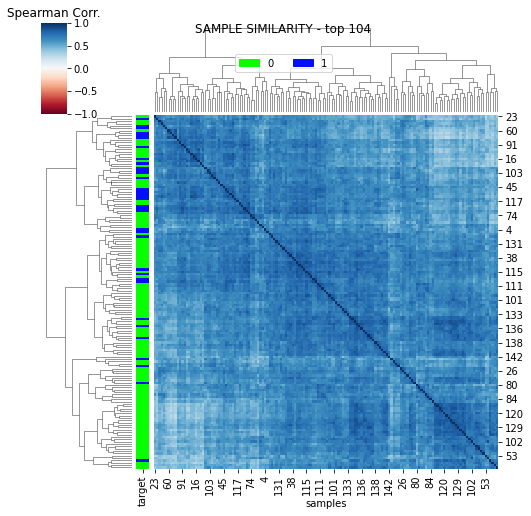

............................................................
GENE EXPRESSION IN THE TOP 
 104 differencially expressed genes
............................................................


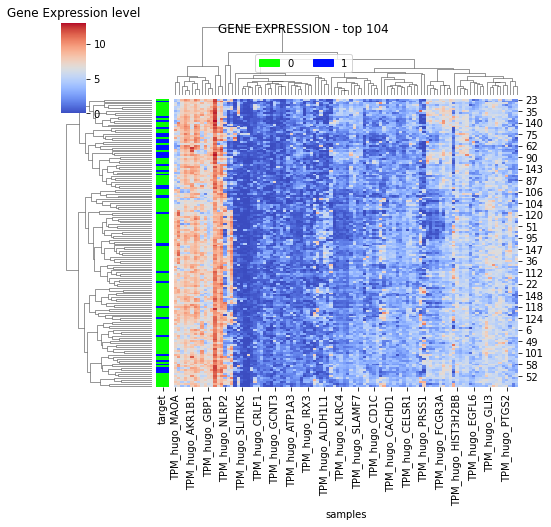

............................................................
PCA and tSNE analysis
............................................................


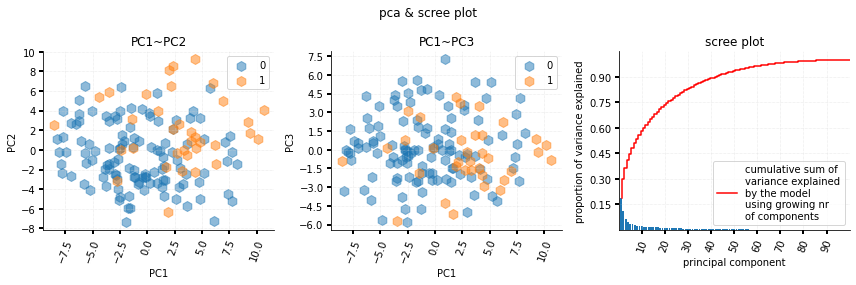


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            105053.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.8%  59.8%   
% of genes not expressed in any sample               22.1%  22.1%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  45.5%  45.5%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.5%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        98.9%   
% of genes expressed in all samples                     76.3%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.5%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               98.9%   
% of genes expressed in all samples                            76.3%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18550       104   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.7   
max tpm value recorded                                       16.7      13.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.5%     97.1%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            98.9%     99.0%   
% of genes expressed in all samples                         76.3%     71.2%   

                                                 after pca  
sample nr                                               50  
gene nr                                                104  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            76.4%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18550       104   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.4   
mean tpm value recorded                                       3.1       3.8   
max tpm value recorded                                       17.0      13.2   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.0%     97.5%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%    100.0%   
% of genes expressed in all samples                         76.4%     73.1%   

                                                 after pca  
sample nr                                               98  
gene nr                                                104  
- VALUES -                                                  
min tpm value recorded                                 0.0  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 104)
df2 shape:  (150, 50)
final df:  (150, 154)

validation data ...
df1 shape:  (50, 104)
df2 shape:  (50, 50)
final df:  (50, 154)

test data ...
df1 shape:  (98, 104)
df2 shape:  (98, 50)
final df:  (98, 154)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G100_LOG_v2__transf_data_dct.p
SAVED:  P17_G100_LOG_v2__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 1

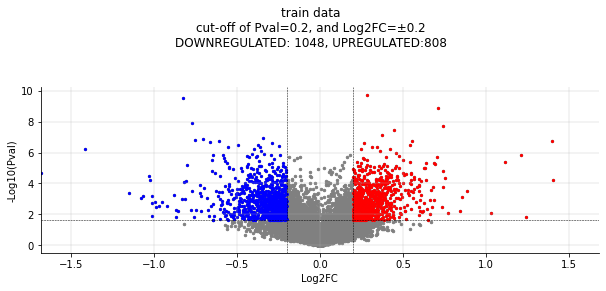


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.6%  44.6%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.7%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            74.7%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       18.3      15.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     97.7%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         74.7%     78.9%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -35.6  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 1856 
differencially expressed genes
............................................................


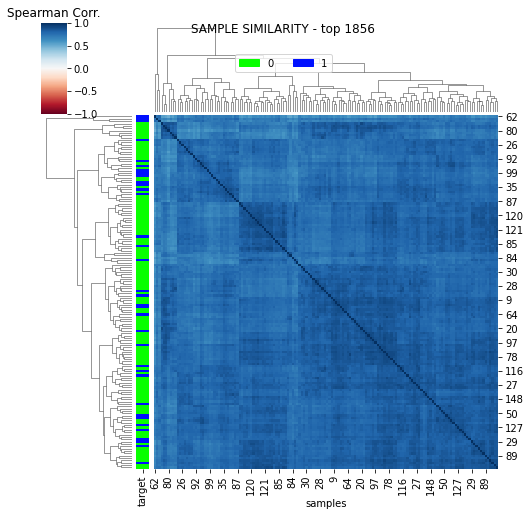

............................................................
GENE EXPRESSION IN THE TOP 
 1856 differencially expressed genes
............................................................


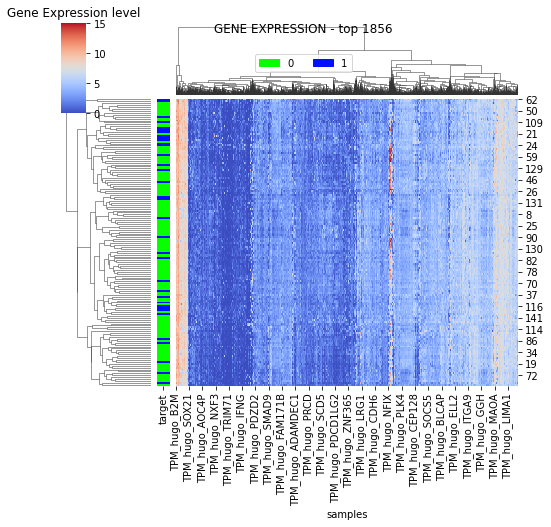

............................................................
PCA and tSNE analysis
............................................................


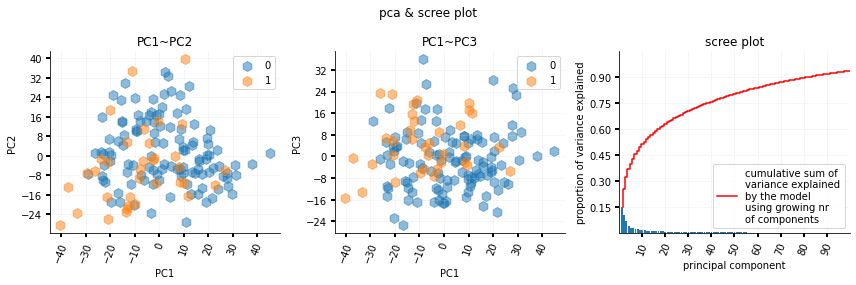


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            105053.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.8%  59.8%   
% of genes not expressed in any sample               22.1%  22.1%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  45.5%  45.5%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.5%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        98.9%   
% of genes expressed in all samples                     76.3%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.5%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               98.9%   
% of genes expressed in all samples                            76.3%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       16.7      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.5%     97.4%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            98.9%     99.4%   
% of genes expressed in all samples                         76.3%     80.9%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -38.3  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            76.4%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.0%     97.8%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%     99.7%   
% of genes expressed in all samples                         76.4%     81.3%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -30.3  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_v2__transf_data_dct.p
SAVED:  P17_G2000_LOG_v2__qc_reports_dct.p

train data: outlier removal step
REMOVED []
ACCEPTED [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,

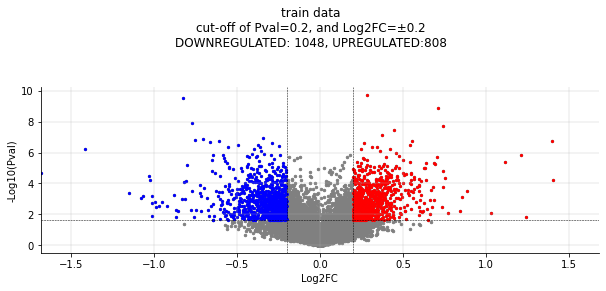


............................................................
 train - Step 1-5
............................................................



input    log  \
sample nr                                              150    150   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            314419.1   18.3   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.2%  60.2%   
% of genes not expressed in any sample               18.3%  18.3%   
% of genes expressed in at least 50%  of samples     59.7%  59.7%   
% of genes expressed in all samples                  44.6%  44.6%   

                                                 log_filtered  \
sample nr                                                 150   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   18.3   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.9%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples       100.0%   
% of genes expressed in all samples                     74.7%   

                                                 log_filtered_scaled  \
sample nr                                                        150   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          18.3   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.9%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples              100.0%   
% of genes expressed in all samples                            74.7%   

                                                 outliers_removed top_genes  \
sample nr                                                     150       150   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       18.3      15.1   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.9%     97.7%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples           100.0%    100.0%   
% of genes expressed in all samples                         74.7%     78.9%   

                                                 after pca  
sample nr                                              150  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -35.6  
median tpm value recorded              

............................................................
SIMILARITY BEWEEN SAMPLES
BASED ON GENE EXPRESSION IN THE TOP 1856 
differencially expressed genes
............................................................


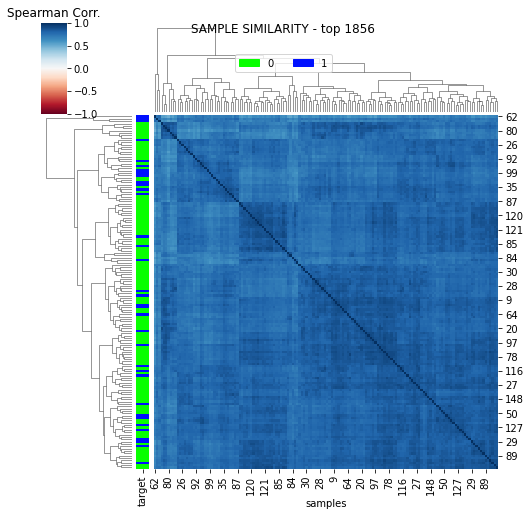

............................................................
GENE EXPRESSION IN THE TOP 
 1856 differencially expressed genes
............................................................


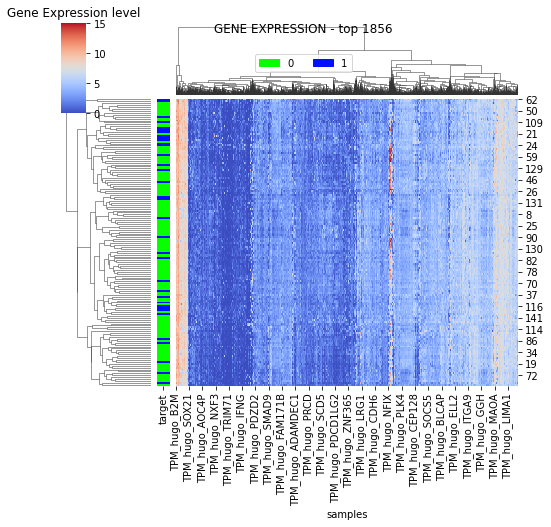

............................................................
PCA and tSNE analysis
............................................................


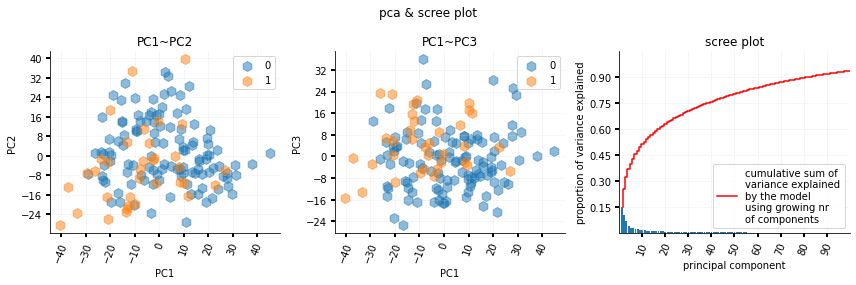


............................................................
 test0 - Step 1-5
............................................................



input    log  \
sample nr                                               50     50   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            105053.5   16.7   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 59.8%  59.8%   
% of genes not expressed in any sample               22.1%  22.1%   
% of genes expressed in at least 50%  of samples     59.4%  59.4%   
% of genes expressed in all samples                  45.5%  45.5%   

                                                 log_filtered  \
sample nr                                                  50   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   16.7   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    95.5%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        98.9%   
% of genes expressed in all samples                     76.3%   

                                                 log_filtered_scaled  \
sample nr                                                         50   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          16.7   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           95.5%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               98.9%   
% of genes expressed in all samples                            76.3%   

                                                 outliers_removed top_genes  \
sample nr                                                      50        50   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       16.7      15.0   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        95.5%     97.4%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            98.9%     99.4%   
% of genes expressed in all samples                         76.3%     80.9%   

                                                 after pca  
sample nr                                               50  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -38.3  
median tpm value recorded              


............................................................
 test1 - Step 1-5
............................................................



input    log  \
sample nr                                               98     98   
gene nr                                              31085  31085   
- VALUES -                                                          
min tpm value recorded                                 0.0    0.0   
median tpm value recorded                              0.3    0.4   
mean tpm value recorded                               32.2    1.8   
max tpm value recorded                            133685.0   17.0   
- DETECTED IN -                                                     
mean % of genes expressed per sample                 60.4%  60.4%   
% of genes not expressed in any sample               19.6%  19.6%   
% of genes expressed in at least 50%  of samples     60.0%  60.0%   
% of genes expressed in all samples                  45.6%  45.6%   

                                                 log_filtered  \
sample nr                                                  98   
gene nr                                                 18550   
- VALUES -                                                      
min tpm value recorded                                    0.0   
median tpm value recorded                                 2.9   
mean tpm value recorded                                   3.1   
max tpm value recorded                                   17.0   
- DETECTED IN -                                                 
mean % of genes expressed per sample                    96.0%   
% of genes not expressed in any sample                   0.0%   
% of genes expressed in at least 50%  of samples        99.4%   
% of genes expressed in all samples                     76.4%   

                                                 log_filtered_scaled  \
sample nr                                                         98   
gene nr                                                        18550   
- VALUES -                                                             
min tpm value recorded                                           0.0   
median tpm value recorded                                        2.9   
mean tpm value recorded                                          3.1   
max tpm value recorded                                          17.0   
- DETECTED IN -                                                        
mean % of genes expressed per sample                           96.0%   
% of genes not expressed in any sample                          0.0%   
% of genes expressed in at least 50%  of samples               99.4%   
% of genes expressed in all samples                            76.4%   

                                                 outliers_removed top_genes  \
sample nr                                                      98        98   
gene nr                                                     18550      1856   
- VALUES -                                                                    
min tpm value recorded                                        0.0       0.0   
median tpm value recorded                                     2.9       3.1   
mean tpm value recorded                                       3.1       3.3   
max tpm value recorded                                       17.0      14.8   
- DETECTED IN -                                                               
mean % of genes expressed per sample                        96.0%     97.8%   
% of genes not expressed in any sample                       0.0%      0.0%   
% of genes expressed in at least 50%  of samples            99.4%     99.7%   
% of genes expressed in all samples                         76.4%     81.3%   

                                                 after pca  
sample nr                                               98  
gene nr                                                150  
- VALUES -                                                  
min tpm value recorded                               -30.3  
median tpm value recorded              



----------------------------------------

train data ...
df1 shape:  (150, 150)
df2 shape:  (150, 50)
final df:  (150, 200)

validation data ...
df1 shape:  (50, 150)
df2 shape:  (50, 50)
final df:  (50, 200)

test data ...
df1 shape:  (98, 150)
df2 shape:  (98, 50)
final df:  (98, 200)
----------------------------------------


PWD:  /Users/pawel/Desktop/activities/100__Projects/Ardigen/Ardigen/data/interim
SAVED:  P17_G2000_LOG_PCA_v2__transf_data_dct.p
SAVED:  P17_G2000_LOG_PCA_v2__qc_reports_dct.p


In [12]:
for random_nr in random_nr_list:

    # create test/validation dataset

    # . set seed
    np.random.seed(random_nr)

    # . create idx, for test/valid datasets
    idx_list = list(range(target.shape[0]))
    np.random.shuffle(idx_list)
    valid_idx = idx_list[0:n]; print(len(valid_idx))
    train_idx = idx_list[n:200]; print(len(train_idx))

    # . hand made methods - I had some issues with indexes
    data_genes_train = data_genes.iloc[train_idx,:]
    data_genes_train.reset_index(inplace=True, drop=True)
    target_train = target.iloc[train_idx]
    target_train.reset_index(inplace=True, drop=True)
    data_cov_train = data_cov.iloc[train_idx,:]
    data_cov_train.reset_index(inplace=True, drop=True)

    # . validation 
    data_genes_valid = data_genes.iloc[valid_idx,:]
    data_genes_valid.reset_index(inplace=True, drop=True)
    target_valid = target.iloc[valid_idx]
    target_valid.reset_index(inplace=True, drop=True)
    data_cov_valid = data_cov.iloc[valid_idx,:]
    data_cov_valid.reset_index(inplace=True, drop=True)

    # . run preprocessing pipeline
    for data_set_name in list(parameters.keys()):

        transf_data, qc_reports = data_preprocessing_pipeline(
            # ..
            x_train=data_genes_train,
            y_train=target_train,
            cov=data_cov_train,
            cov_data_preprocessor=preprocessor,
            # ..
            x_test_list = [data_genes_valid, data_genes_test],
            y_test_list = [target_valid, None],
            cov_list = [data_cov_valid, data_cov_test],
            # ...
            verbose=1, 
            make_hist=True, 
            **parameters[data_set_name]
            ) 


        # check file dimensions by using my other function for merging files,

        print(f"\n\n{''.join(['-']*40)}")
        dataset_dct = transf_data

        print("\ntrain data ...")
        x_train = merge_data(dataset_dct["tpm_data"]["train"], dataset_dct["covariants_data"]["train"])
        y_train = dataset_dct['target_data']["train"]

        print("\nvalidation data ...")
        x_valid = merge_data(dataset_dct["tpm_data"]["test0"], dataset_dct["covariants_data"]["test0"])
        y_valid = dataset_dct['target_data']["test0"]

        print("\ntest data ...")
        x_test = merge_data(dataset_dct["tpm_data"]["test1"], dataset_dct["covariants_data"]["test1"])
        print(f"{''.join(['-']*40)}\n\n")


        # save the results


        os.chdir(path)
        print("PWD: ", path)

        # . file name
        prefix = f'{data_set_name}_v{random_nr}'

        # . save pickle - its fast, but dont use if you dont trust 
        fname = f"{prefix}__transf_data_dct.p"
        with open(fname, 'wb') as file: # wb - write binary,
                    pickle.dump(transf_data, file) 
        print("SAVED: ", fname)

        # . save pickle - its fast, but dont use if you dont trust 
        fname = f"{prefix}__qc_reports_dct.p"
        with open(fname, 'wb') as file: # wb - write binary,
                    pickle.dump(qc_reports, file) 
        print("SAVED: ", fname)
